<a href="https://colab.research.google.com/github/ctrivino1/ML_class_final/blob/main/Chris_Trivino_final_project_exp_weight_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Libraries

In [1]:
!pip install pyforest
!pip install git+https://github.com/keras-team/keras-preprocessing.git
!pip install keras-rectified-adam
!pip install tensorflow_addons
import tensorflow_addons as tfa
from keras_radam import RAdam
import pyforest
import shutil, os
from keras_preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras_radam import RAdam
import datetime
%load_ext tensorboard
from tensorflow.python.keras.callbacks import TensorBoard
from sklearn.utils import class_weight
import numpy as np



  Created wheel for pyforest: filename=pyforest-1.1.0-py2.py3-none-any.whl size=14607 sha256=8381ebdf5fb65b5ad3cadd1636b5684cab3d58057a5f598efcfe6a1ff826db82
  Stored in directory: /root/.cache/pip/wheels/61/1c/da/48e6c884142d485475d852d69d20a096aba5beceb338822893
Successfully built pyforest
  Cloning https://github.com/keras-team/keras-preprocessing.git to /tmp/pip-req-build-og85ek8a
  Running command git clone -q https://github.com/keras-team/keras-preprocessing.git /tmp/pip-req-build-og85ek8a
  Created wheel for keras-rectified-adam: filename=keras_rectified_adam-0.19.0-py3-none-any.whl size=9017 sha256=bf8d7e3fddf441349f7cd32723f929cd95fe12d927aab475e2e043f8480d03fa
  Stored in directory: /root/.cache/pip/wheels/52/1d/66/374c85b327ea412af5301b4811088408d9764314d6cfb8f127
Successfully built keras-rectified-adam
     |████████████████████████████████| 1.1 MB 4.3 MB/s 


In [2]:
!git clone https://github.com/ctrivino1/ML_class_final.git


Cloning into 'ML_class_final'...
remote: Enumerating objects: 21471, done.
remote: Total 21471 (delta 0), reused 0 (delta 0), pack-reused 21471
Receiving objects: 100% (21471/21471), 2.38 GiB | 14.23 MiB/s, done.
Resolving deltas: 100% (41/41), done.
Checking out files: 100% (21402/21402), done.


In [3]:
training_dir = "/content/ML_class_final/train_imgs_1"
test_dir = "/content/ML_class_final/test_imgs_1"
df=pd.read_csv("/content/ML_class_final/train_1.csv")
df.label = df.label.astype(str)
df.label.value_counts()

<IPython.core.display.Javascript object>

3    10533
4     2044
2     1920
1     1758
0      862
Name: label, dtype: int64

In [4]:
train_datagen=ImageDataGenerator(rescale=1./255,shear_range=.2,zoom_range=.2,horizontal_flip=True,width_shift_range=0.2,height_shift_range=0.2,validation_split=.2,)


train_generator = train_datagen.flow_from_dataframe(dataframe=df, 
                                         directory=training_dir, 
                                         x_col="image_id", 
                                         y_col="label", 
                                         class_mode="categorical", 
                                         target_size=(256,256), 
                                         batch_size=64,
                                         subset="training",
                                         seed=69,
                                         )






Found 13694 validated image filenames belonging to 5 classes.


In [5]:
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
valid_generator = val_datagen.flow_from_dataframe(dataframe=df, 
                                         directory=training_dir, 
                                         x_col="image_id", 
                                         y_col="label", 
                                         class_mode="categorical", 
                                         target_size=(256,256), 
                                         batch_size=64,
                                         subset="validation",
                                         seed=69)



Found 3423 validated image filenames belonging to 5 classes.


In [6]:
## since the dataset is imbalanced lets try to weight the classes differently. 
## this is experimental code that I found online
from sklearn.utils import compute_class_weight
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_generator.classes),
                                        y = train_generator.classes                                                    
                                    )
class_weights = dict(zip(np.unique(train_generator.classes), class_weights))
class_weights

{0: 3.884822695035461,
 1: 1.9451704545454545,
 2: 1.7784415584415585,
 3: 0.3258536585365854,
 4: 1.6740831295843521}

In [8]:

resnet50 = tf.keras.applications.ResNet50(
    include_top=False, weights='imagenet', input_tensor=None,
    input_shape=(256,256,3), pooling="max")


vgg16 = tf.keras.applications.VGG16(
    include_top=False, weights='imagenet', input_tensor=None,
    input_shape=(256,256,3), pooling="max")

# Freeze the pretrained CNN's
resnet50.trainable = False
vgg16.trainable = False

# optimizers
radam = tfa.optimizers.RectifiedAdam(learning_rate=1e-3)

# Adds ResNet50 into a model with a output layers with 5 classifaction nodes
model = keras.Sequential([vgg16,
    tf.keras.layers.Dense(units=256, activation='LeakyReLU'),
    tf.keras.layers.Dense(units=256, activation='LeakyReLU'),
    tf.keras.layers.Dense(units=128, activation='LeakyReLU'),
    tf.keras.layers.Dense(5,activation="softmax") # number of perceptrons
])
model.compile(loss="categorical_crossentropy",
optimizer=radam, metrics=['acc'])
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size


model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='/tmp/checkpoint', #creates a temporary folder that will store the model weight associated with the best val_acc score. 
    monitor='val_acc',
    mode='max',
    save_best_only=True)

history = model.fit(train_generator, 
                    validation_data = valid_generator,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_steps = STEP_SIZE_VALID,
                    class_weight=class_weights, # trying out the weights from the experimental code I got
                    callbacks=[model_checkpoint_callback],
                    batch_size=64,
                    epochs=15,)



Epoch 1/15
213/213 [==============================] - ETA: 0s - loss: 1.4674 - acc: 0.4389

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


213/213 [==============================] - 278s 1s/step - loss: 1.4674 - acc: 0.4389 - val_loss: 1.2212 - val_acc: 0.5542
Epoch 2/15
213/213 [==============================] - 274s 1s/step - loss: 1.3249 - acc: 0.5348 - val_loss: 1.3757 - val_acc: 0.4057
Epoch 3/15
213/213 [==============================] - 273s 1s/step - loss: 1.2837 - acc: 0.5531 - val_loss: 1.1988 - val_acc: 0.5466
Epoch 4/15
213/213 [==============================] - 273s 1s/step - loss: 1.2742 - acc: 0.5464 - val_loss: 1.2957 - val_acc: 0.4443
Epoch 5/15
213/213 [==============================] - ETA: 0s - loss: 1.2433 - acc: 0.5552

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


213/213 [==============================] - 273s 1s/step - loss: 1.2433 - acc: 0.5552 - val_loss: 1.0719 - val_acc: 0.5722
Epoch 6/15
213/213 [==============================] - ETA: 0s - loss: 1.2336 - acc: 0.5575

INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


213/213 [==============================] - 275s 1s/step - loss: 1.2336 - acc: 0.5575 - val_loss: 0.9669 - val_acc: 0.6580
Epoch 7/15
213/213 [==============================] - 272s 1s/step - loss: 1.2159 - acc: 0.5698 - val_loss: 1.1872 - val_acc: 0.4876
Epoch 8/15
213/213 [==============================] - 274s 1s/step - loss: 1.2055 - acc: 0.5740 - val_loss: 1.4341 - val_acc: 0.3912
Epoch 9/15
213/213 [==============================] - 274s 1s/step - loss: 1.1923 - acc: 0.5838 - val_loss: 1.4736 - val_acc: 0.3992
Epoch 10/15
213/213 [==============================] - 274s 1s/step - loss: 1.2120 - acc: 0.5608 - val_loss: 1.2928 - val_acc: 0.4422
Epoch 11/15
213/213 [==============================] - 274s 1s/step - loss: 1.1832 - acc: 0.5825 - val_loss: 1.2533 - val_acc: 0.4912
Epoch 12/15
213/213 [==============================] - 274s 1s/step - loss: 1.1730 - acc: 0.5860 - val_loss: 1.0891 - val_acc: 0.5743
Epoch 13/15
213/213 [==============================] - 273s 1s/step - loss: 1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

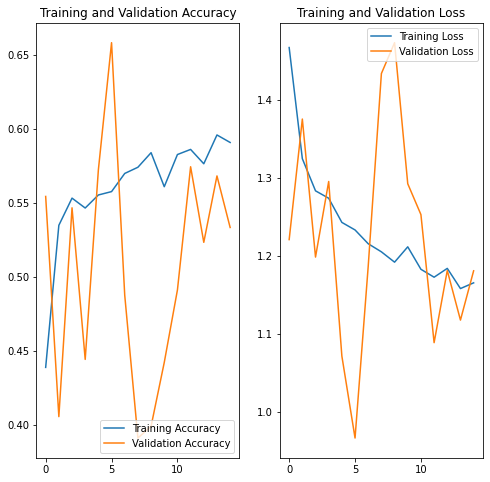

In [9]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
# load model with the best weights that had the highet val_acc
model.load_weights('/tmp/checkpoint')

In [ ]:
#downloading the model as a zipfile

import shutil
model.save('70_perc_model')
shutil.make_archive('70_perc_model', 'zip', '70_perc_model')

In [ ]:
import pathlib


def predict_an_image(model, file_path):
  # Load the image
  img = keras.preprocessing.image.load_img(file_path, target_size=(256, 256))
  # Get the image into the shape we need for our network
  img_array = keras.preprocessing.image.img_to_array(img) 
  img_array = tf.expand_dims(img_array, 0)/255 # resizing the pixel values to 1/255
  # print(img_array[0]) If any number is greater than the range from [0,1] then I know that my images are not scaled correctly
  # Predict the class
  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])
  return np.argmax(score)
# Loop through all images in our test directory and make
# a prediction
testdir = pathlib.Path('/content/ML_class_final/test_imgs_1')
image_paths = (testdir.glob('*.jpg'))
ip = []
pred = []
for image_path in image_paths:
  prediction = predict_an_image(model, str(image_path))
  ip.append(image_path)
  pred.append(prediction)
  #print(image_path, prediction)



In [ ]:
im_path = np.array(ip)
preds = np.array(pred)
df = pd.DataFrame({'Filename':im_path, 'class':preds})
df["class"].value_counts()

In [ ]:
## save the new dataframe to csv
from google.colab import files

df.to_csv('predictions.csv')
files.download('predictions.csv')

In [ ]:
## loading a custom model example:

#new_model = tf.keras.models.load_model("path_of_model",custom_objects={'loss':tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)}